In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import xgboost as xgb
from torch.utils.data import DataLoader, Dataset

from aum import DatasetWithIndex

import sys
sys.path.insert(0, "../")


/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from data_iq.dataiq_class import *
from src.models.neuralnets import *
from src.utils.data_loader import *
from src.utils.utils import *


## Get dataset

In [3]:
dataset = "covid"
(
    train_loader,
    train_data,
    X_train,
    y_train,
    X_test,
    y_test,
    X_train_pd,
    y_train_pd,
    X_test_pd,
    y_test_pd,
    nlabels,
    corr_vals,
    column_ids,
    df,
) = load_dataset(dataset)


In [4]:
plt.style.reload_library()
plt.style.use(["science", "ieee", "no-latex", "notebook", "grid", "vibrant"])
SMALL_SIZE = 10
MEDIUM_SIZE = 50
BIGGER_SIZE = 50

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=14)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=14)  # fontsize of the tick labels
plt.rc("ytick", labelsize=14)  # fontsize of the tick labels
plt.rc("legend", fontsize=14)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title


# Train different base models and log dynamics with dataiq

In [5]:
n_feats = X_train.shape[1]

LEARNING_RATE = 0.001
EPOCHS = 8

# Define multiple different models
nets = [
    Net1(input_size=n_feats, nlabels=nlabels),
    Net2(input_size=n_feats, nlabels=nlabels),
    Net4(input_size=n_feats, nlabels=nlabels),
    Net5(input_size=n_feats, nlabels=nlabels),
]

dataiq_list = []
checkpoint_list = []


for i in range(4):

    train_loader = DataLoader(
        dataset=DatasetWithIndex(train_data), batch_size=128, shuffle=True
    )
    ckpt_nets = []
    net_idx = i
    net = nets[net_idx]
    net.to(device)
    criterion = torch.nn.NLLLoss()

    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

    # Instantiate Data-IQ
    dataiq = DataIQ_Torch(X=X_train, y=y_train, sparse_labels=True)

    for e in range(1, EPOCHS + 1):
        net.train()
        epoch_loss = 0
        epoch_acc = 0
        for X_batch, y_batch, sample_ids in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            sf = nn.LogSoftmax()
            y_pred = net(X_batch)
            _, predicted = torch.max(y_pred.data, 1)

            y_batch = y_batch.to(torch.int64)

            loss = criterion(sf(y_pred), y_batch)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += (predicted == y_batch).sum().item() / len(y_batch)

        # Log Data-IQ
        dataiq.on_epoch_end(net, device=device)
        print(
            f"Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}"
        )
        ckpt_nets.append(deepcopy(net))

    checkpoint_list.append(ckpt_nets)
    dataiq_list.append(dataiq)


../src/models/neuralnets.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = F.softmax(self.output(X))
/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Epoch 001: | Loss: 0.69765 | Acc: 0.476
Epoch 002: | Loss: 0.69427 | Acc: 0.474
Epoch 003: | Loss: 0.68555 | Acc: 0.471
Epoch 004: | Loss: 0.67168 | Acc: 0.476
Epoch 005: | Loss: 0.65536 | Acc: 0.512
Epoch 006: | Loss: 0.64443 | Acc: 0.713
Epoch 007: | Loss: 0.63866 | Acc: 0.715
Epoch 008: | Loss: 0.63203 | Acc: 0.724


../src/models/neuralnets.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = F.softmax(self.output(X))


Epoch 001: | Loss: 0.67859 | Acc: 0.574
Epoch 002: | Loss: 0.67097 | Acc: 0.607
Epoch 003: | Loss: 0.66335 | Acc: 0.681
Epoch 004: | Loss: 0.63621 | Acc: 0.696
Epoch 005: | Loss: 0.60644 | Acc: 0.702
Epoch 006: | Loss: 0.58656 | Acc: 0.711
Epoch 007: | Loss: 0.57808 | Acc: 0.713
Epoch 008: | Loss: 0.57004 | Acc: 0.727


../src/models/neuralnets.py:82: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = F.softmax(self.output(X))


Epoch 001: | Loss: 0.68787 | Acc: 0.521
Epoch 002: | Loss: 0.67049 | Acc: 0.647
Epoch 003: | Loss: 0.65867 | Acc: 0.663
Epoch 004: | Loss: 0.64258 | Acc: 0.700
Epoch 005: | Loss: 0.62616 | Acc: 0.702
Epoch 006: | Loss: 0.60988 | Acc: 0.710
Epoch 007: | Loss: 0.60042 | Acc: 0.711
Epoch 008: | Loss: 0.59113 | Acc: 0.716


../src/models/neuralnets.py:96: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = F.softmax(self.output(X))


Epoch 001: | Loss: 0.68157 | Acc: 0.527
Epoch 002: | Loss: 0.67351 | Acc: 0.617
Epoch 003: | Loss: 0.66203 | Acc: 0.656
Epoch 004: | Loss: 0.64463 | Acc: 0.676
Epoch 005: | Loss: 0.62449 | Acc: 0.686
Epoch 006: | Loss: 0.60781 | Acc: 0.699
Epoch 007: | Loss: 0.59455 | Acc: 0.714
Epoch 008: | Loss: 0.58792 | Acc: 0.718


# Fit an XGBOOST

In [6]:
nest = 10
clf = xgb.XGBClassifier(n_estimators=nest)
clf.fit(X_train, y_train)

# Instantiate Data-IQ
dataiq_xgb = DataIQ_SKLearn(X=X_train, y=y_train)

for i in range(1, nest):
    # Log to Data-IQ
    dataiq_xgb.on_epoch_end(clf=clf, iteration=i)


# Data-IQ vs DataMaps: NN & XGB

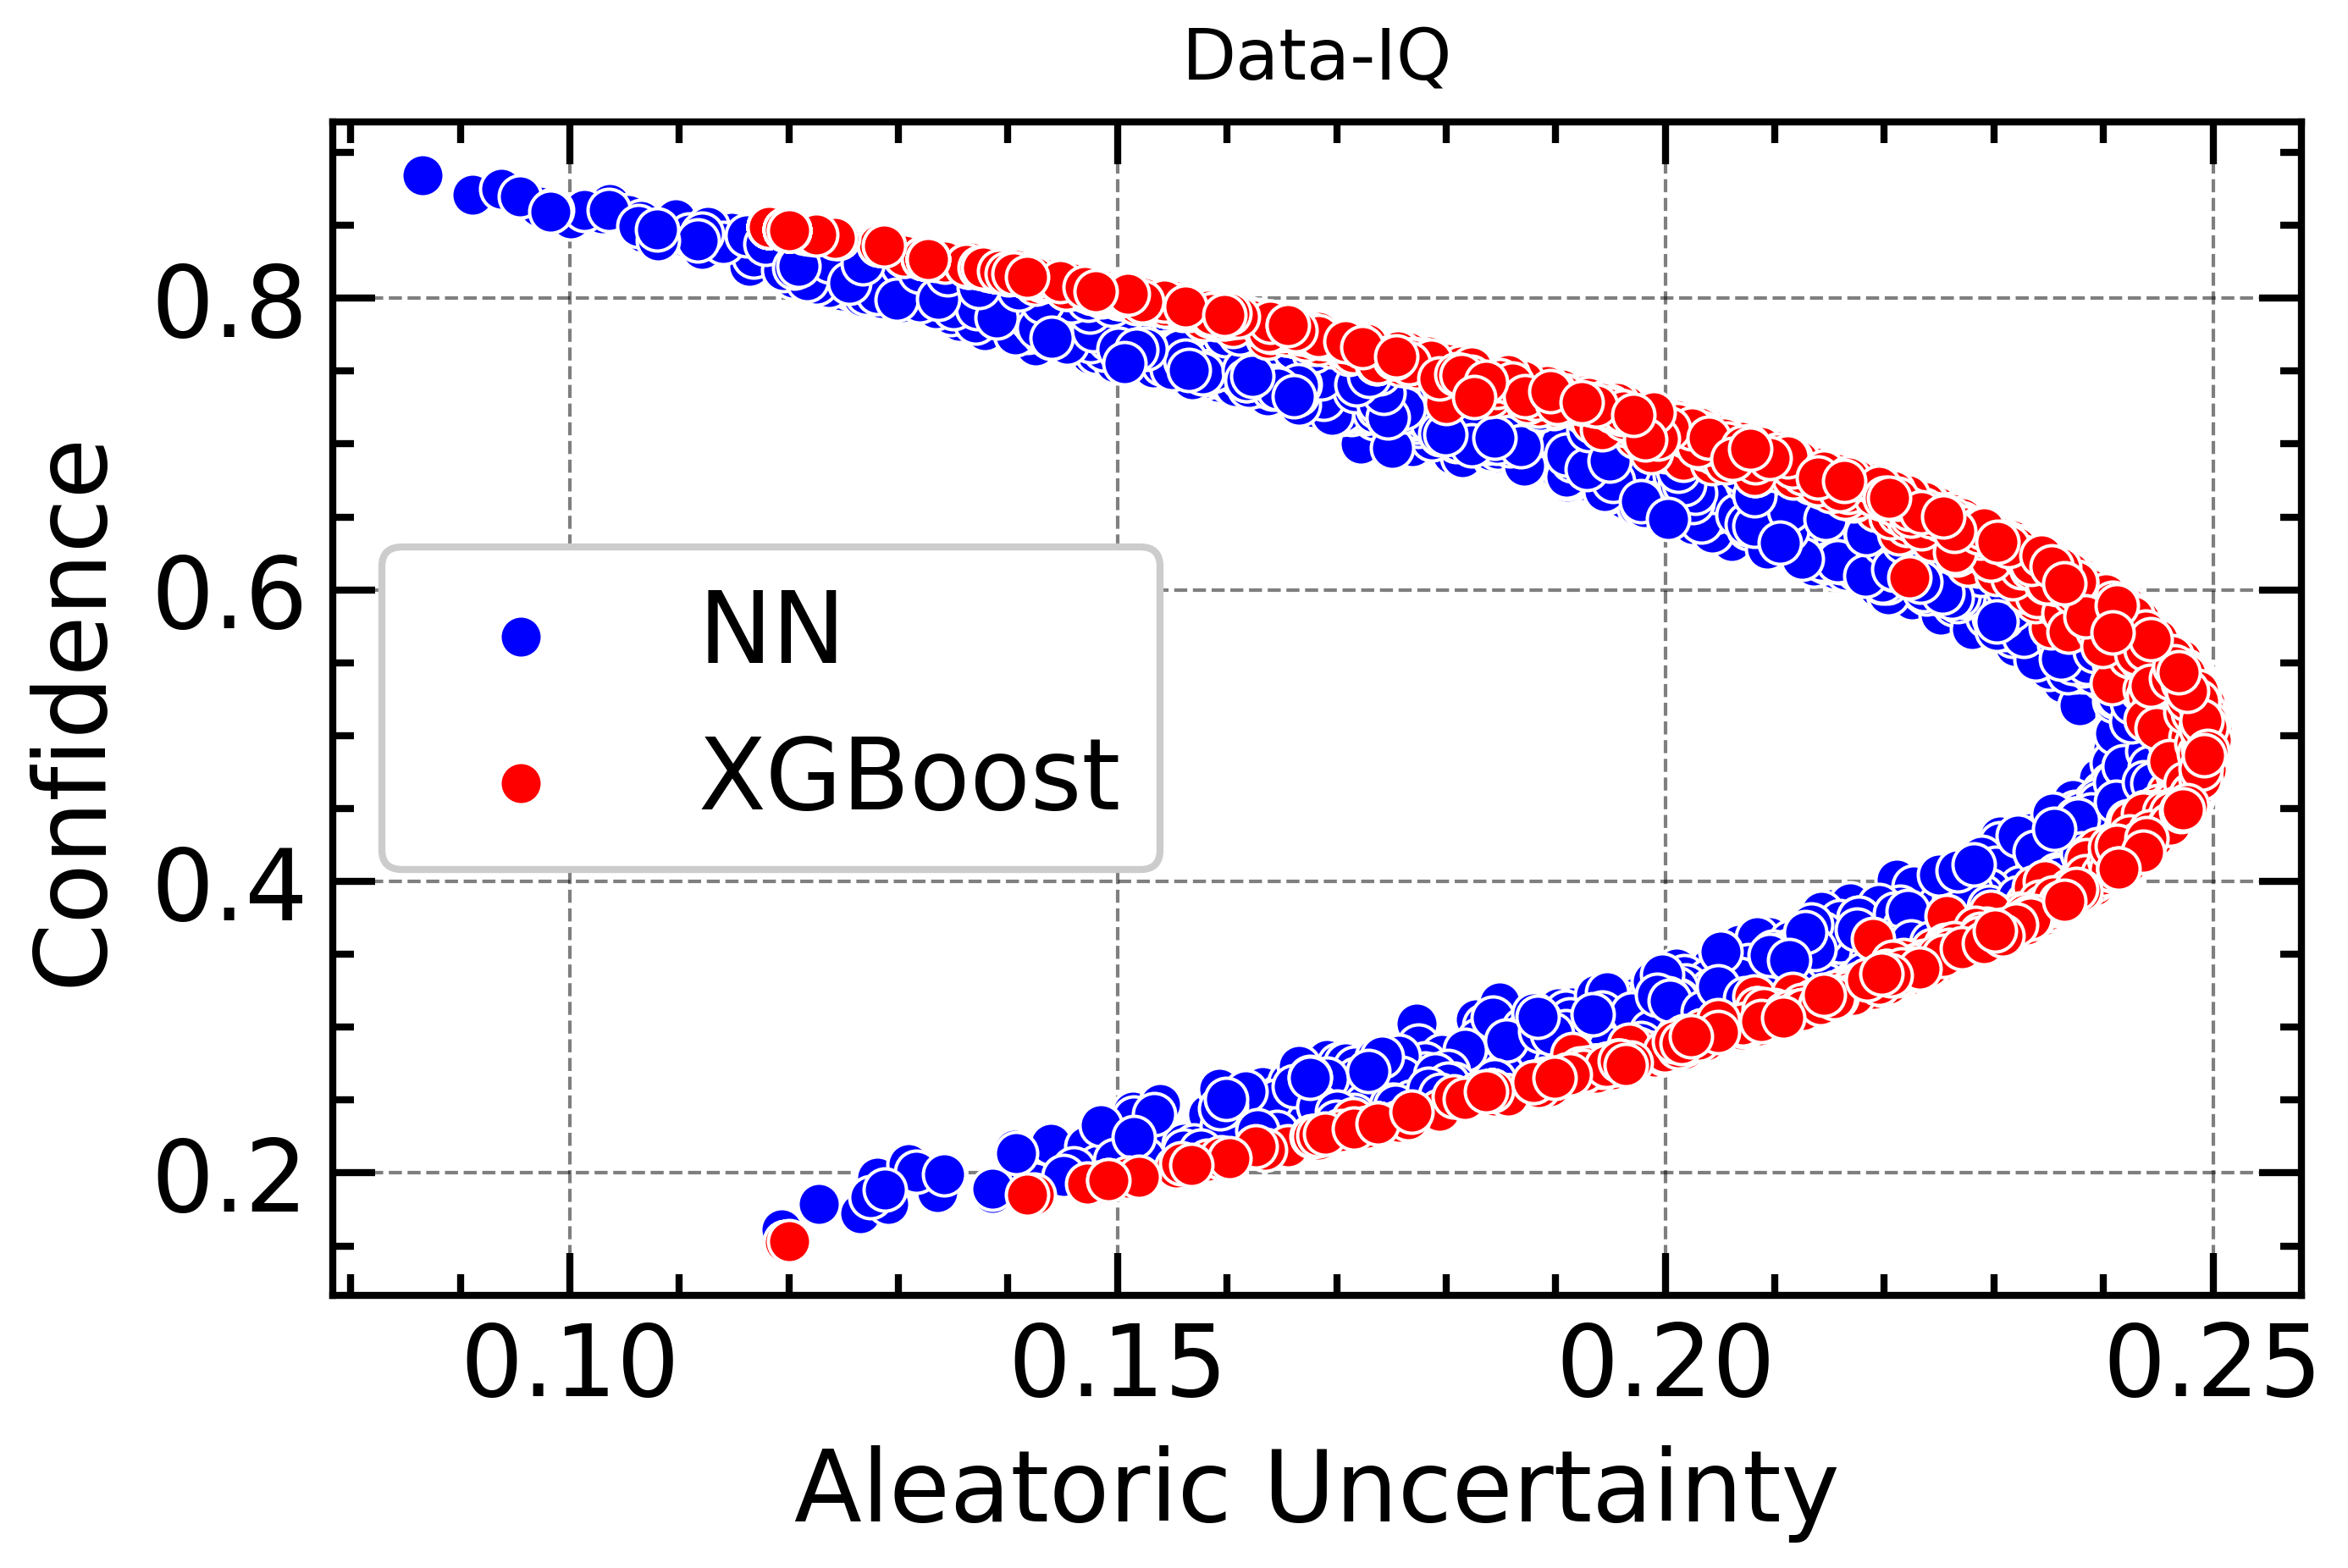

In [7]:
# DATA-IQ
plt.figure(figsize=(5, 3))

sns.scatterplot(
    x=dataiq_list[3].aleatoric, y=dataiq_list[3].confidence, color="b", label="NN"
)

sns.scatterplot(
    x=dataiq_xgb.aleatoric, y=dataiq_xgb.confidence, color="r", label="XGBoost"
)

plt.title("Data-IQ")
plt.xlabel("Aleatoric Uncertainty")
plt.ylabel("Confidence")
plt.show()


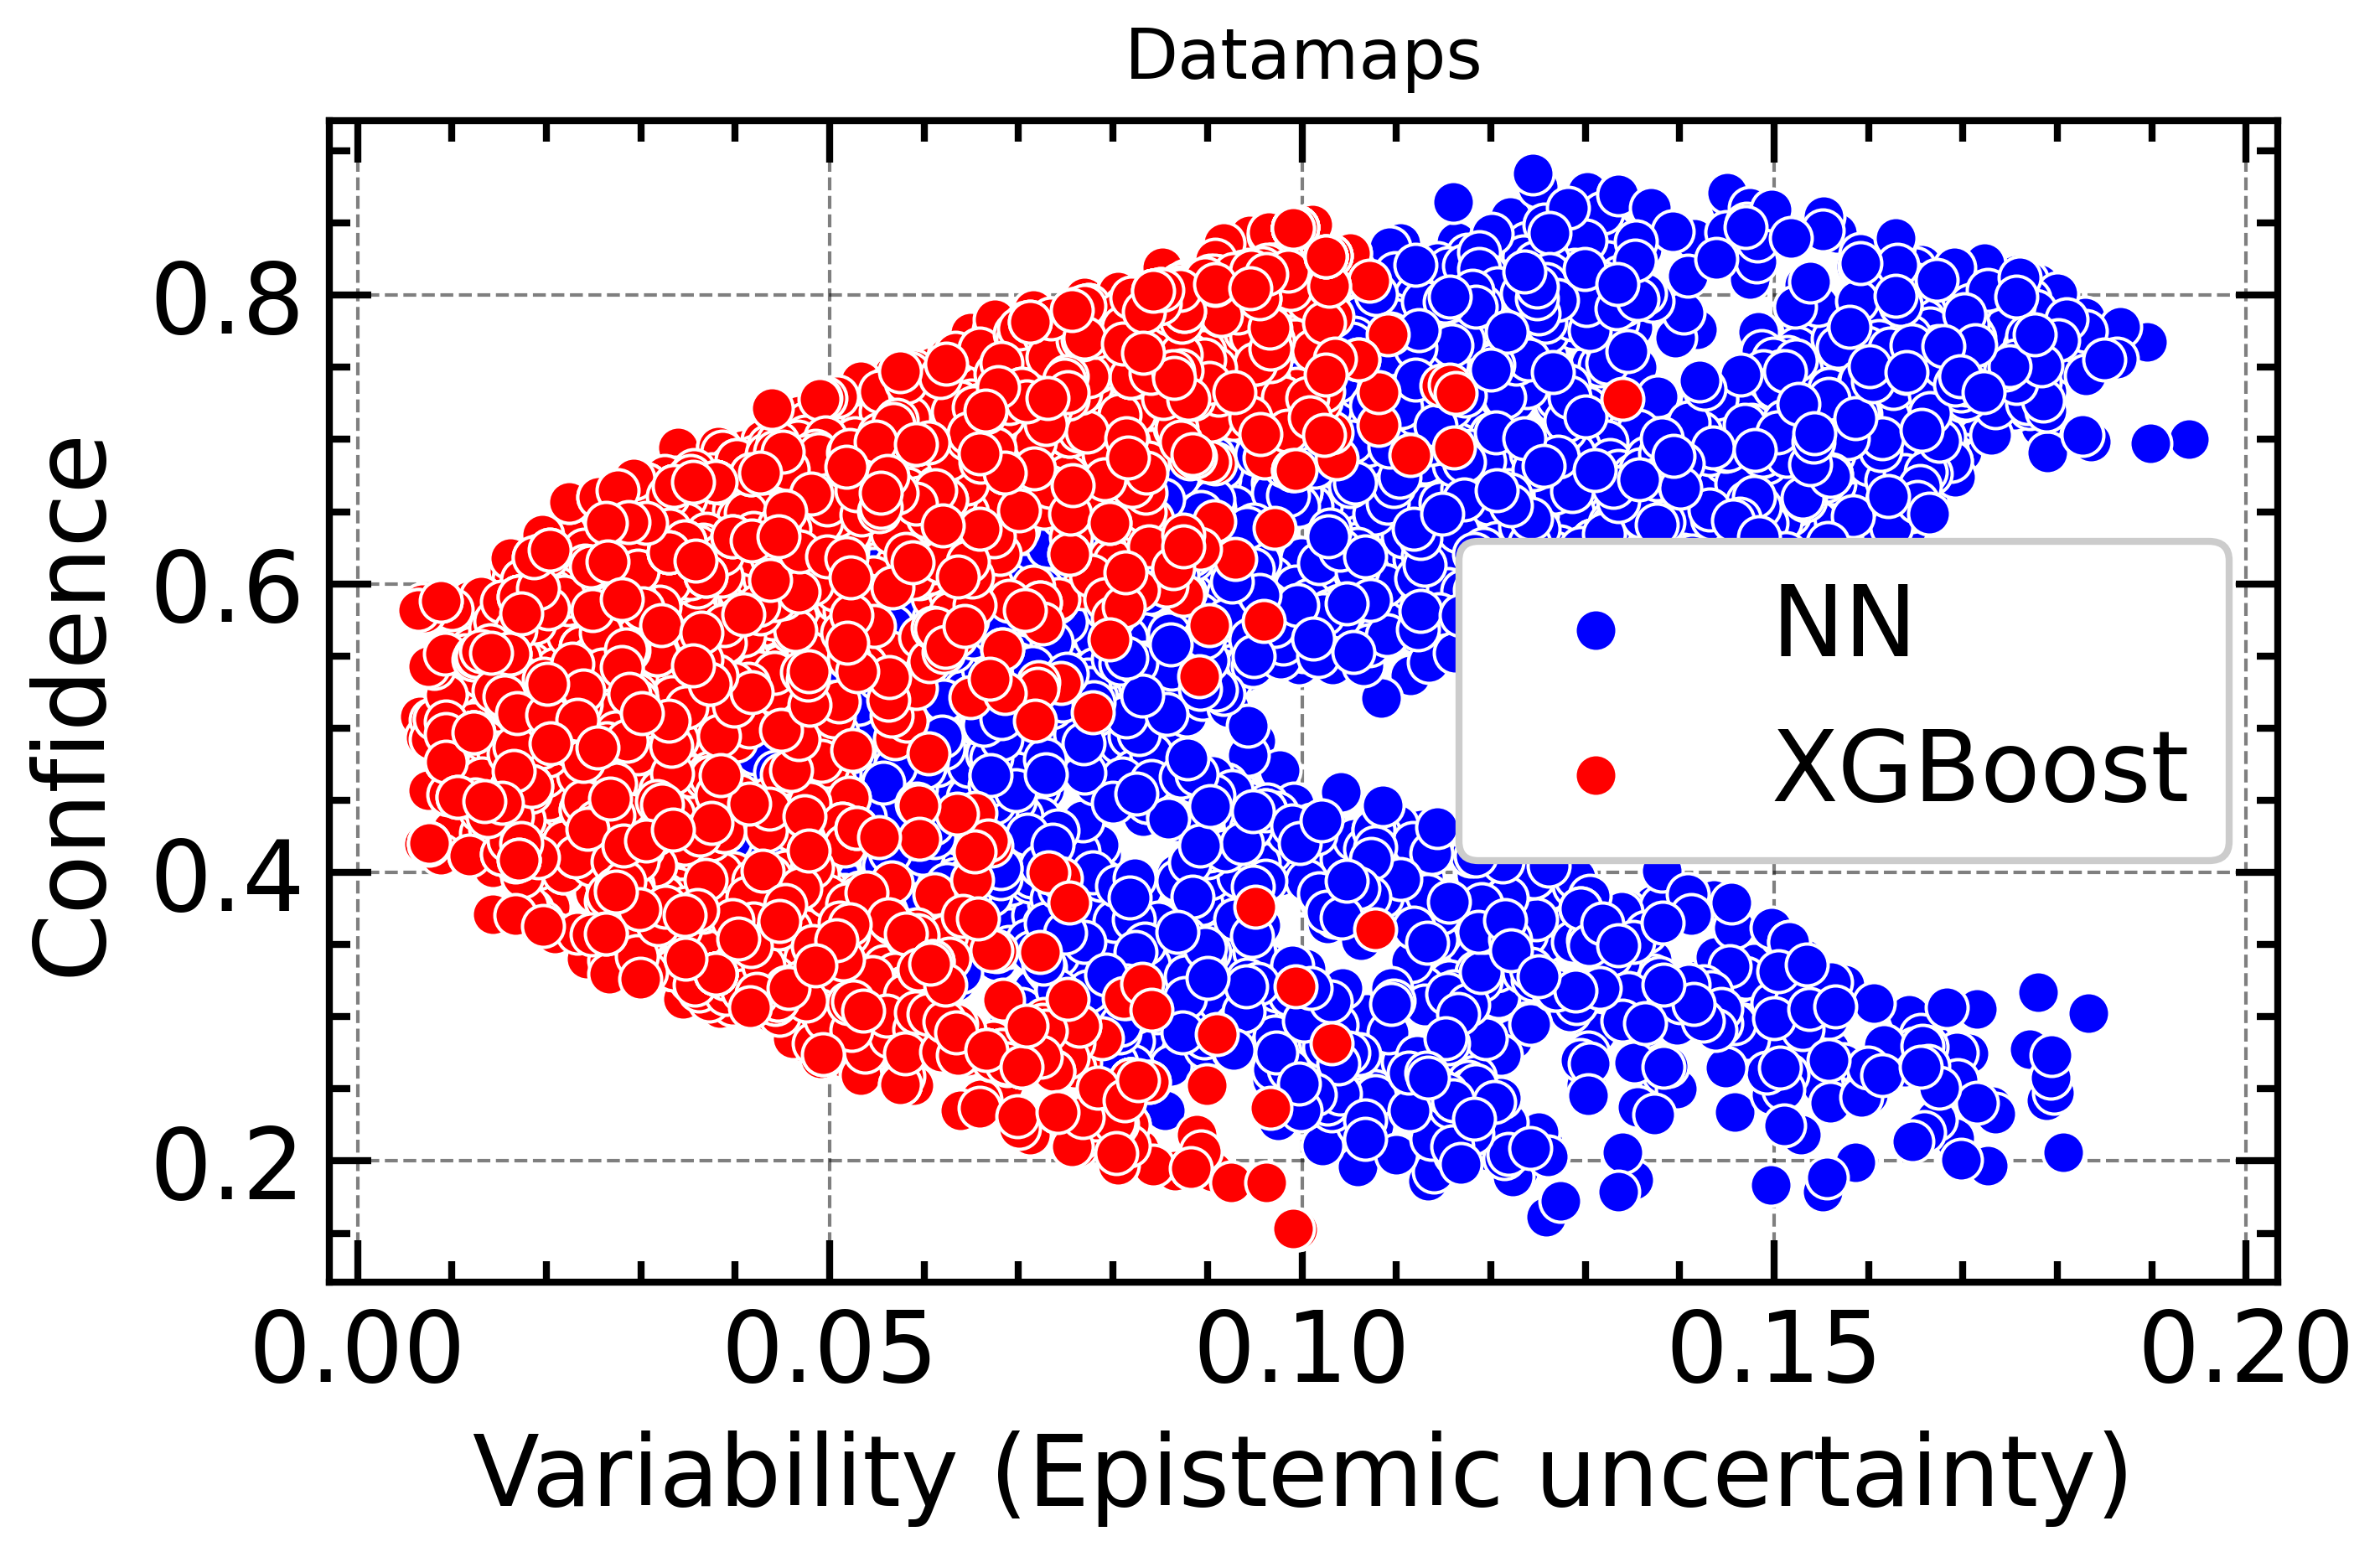

In [8]:
# DATAMAPS
plt.figure(figsize=(5, 3))


idx = 3
sns.scatterplot(
    x=dataiq_list[idx].variability, y=dataiq_list[idx].confidence, color="b", label="NN"
)


sns.scatterplot(
    x=dataiq_xgb.variability, y=dataiq_xgb.confidence, color="r", label="XGBoost"
)
plt.title("Datamaps")
plt.xlabel("Variability (Epistemic uncertainty)")
plt.ylabel("Confidence")
plt.show()


# COMPARING DATA-IQ & DATAMAPS ACORSS MULTIPLE MODELS

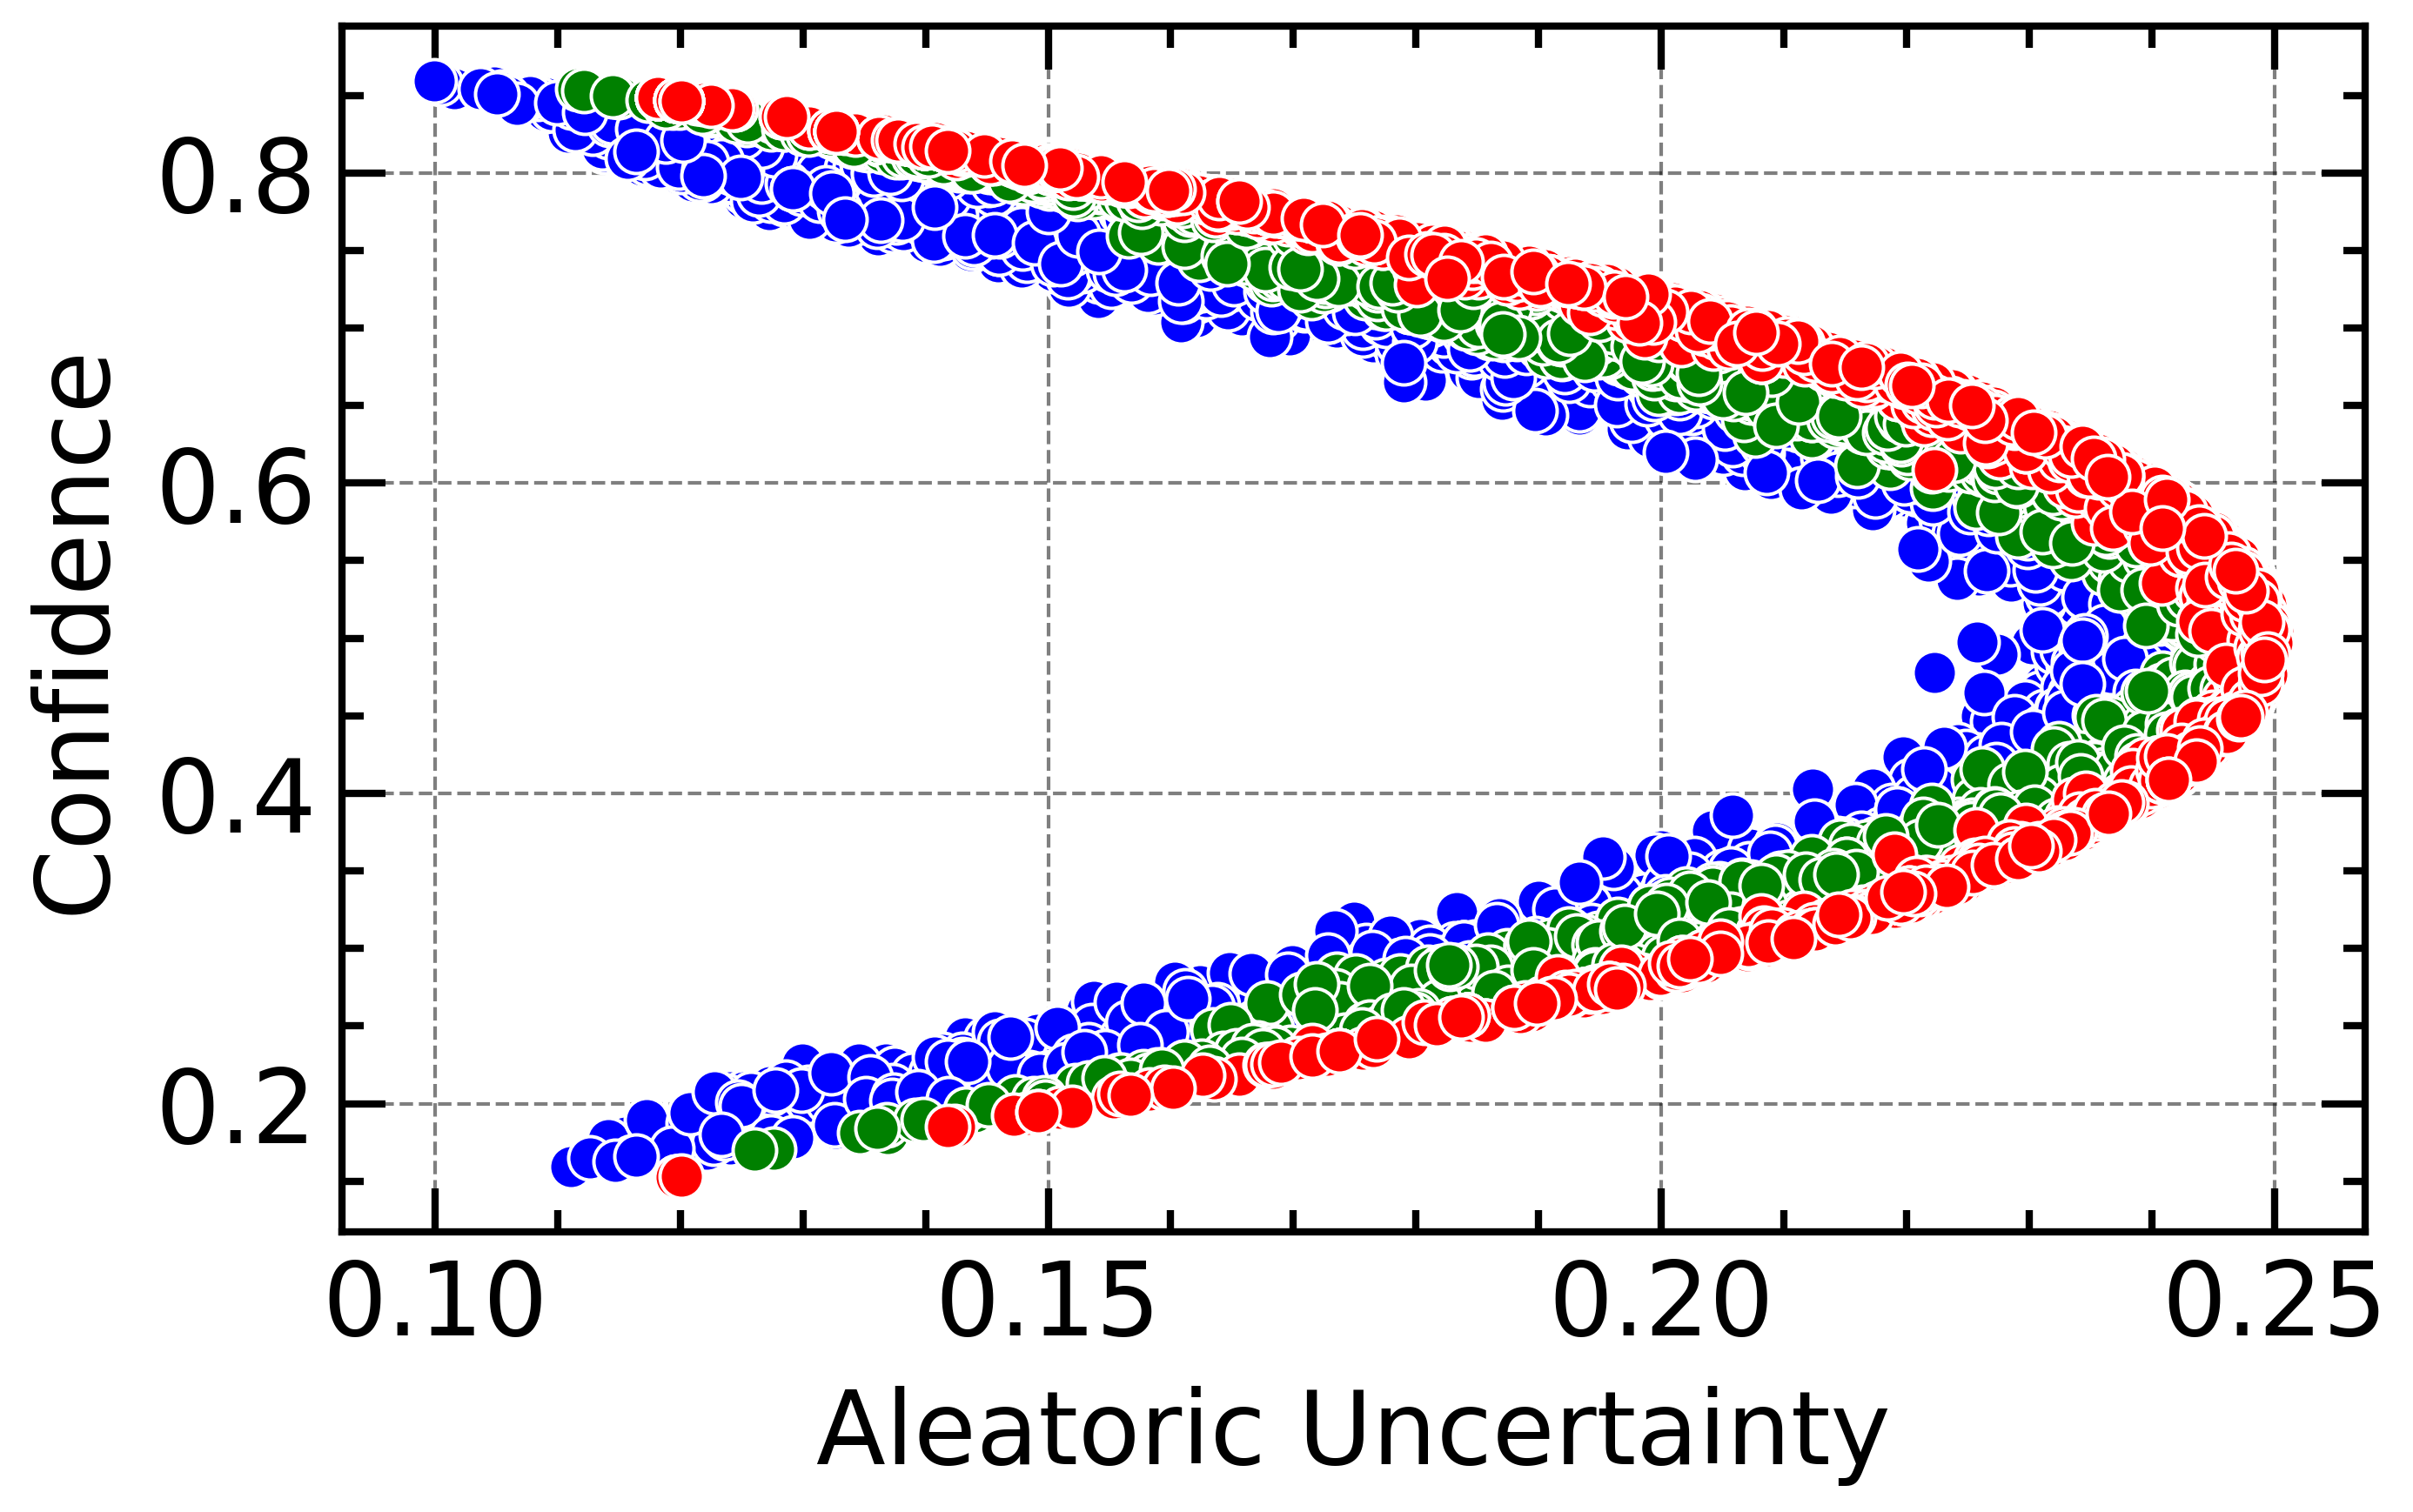

In [9]:
# DATA-IQ
plt.figure(figsize=(5, 3))

sns.scatterplot(x=dataiq_list[1].aleatoric, y=dataiq_list[1].confidence, color="b")

sns.scatterplot(x=dataiq_list[2].aleatoric, y=dataiq_list[2].confidence, color="g")

sns.scatterplot(x=dataiq_xgb.aleatoric, y=dataiq_xgb.confidence, color="r")

plt.xlabel("Aleatoric Uncertainty")
plt.ylabel("Confidence")
plt.show()


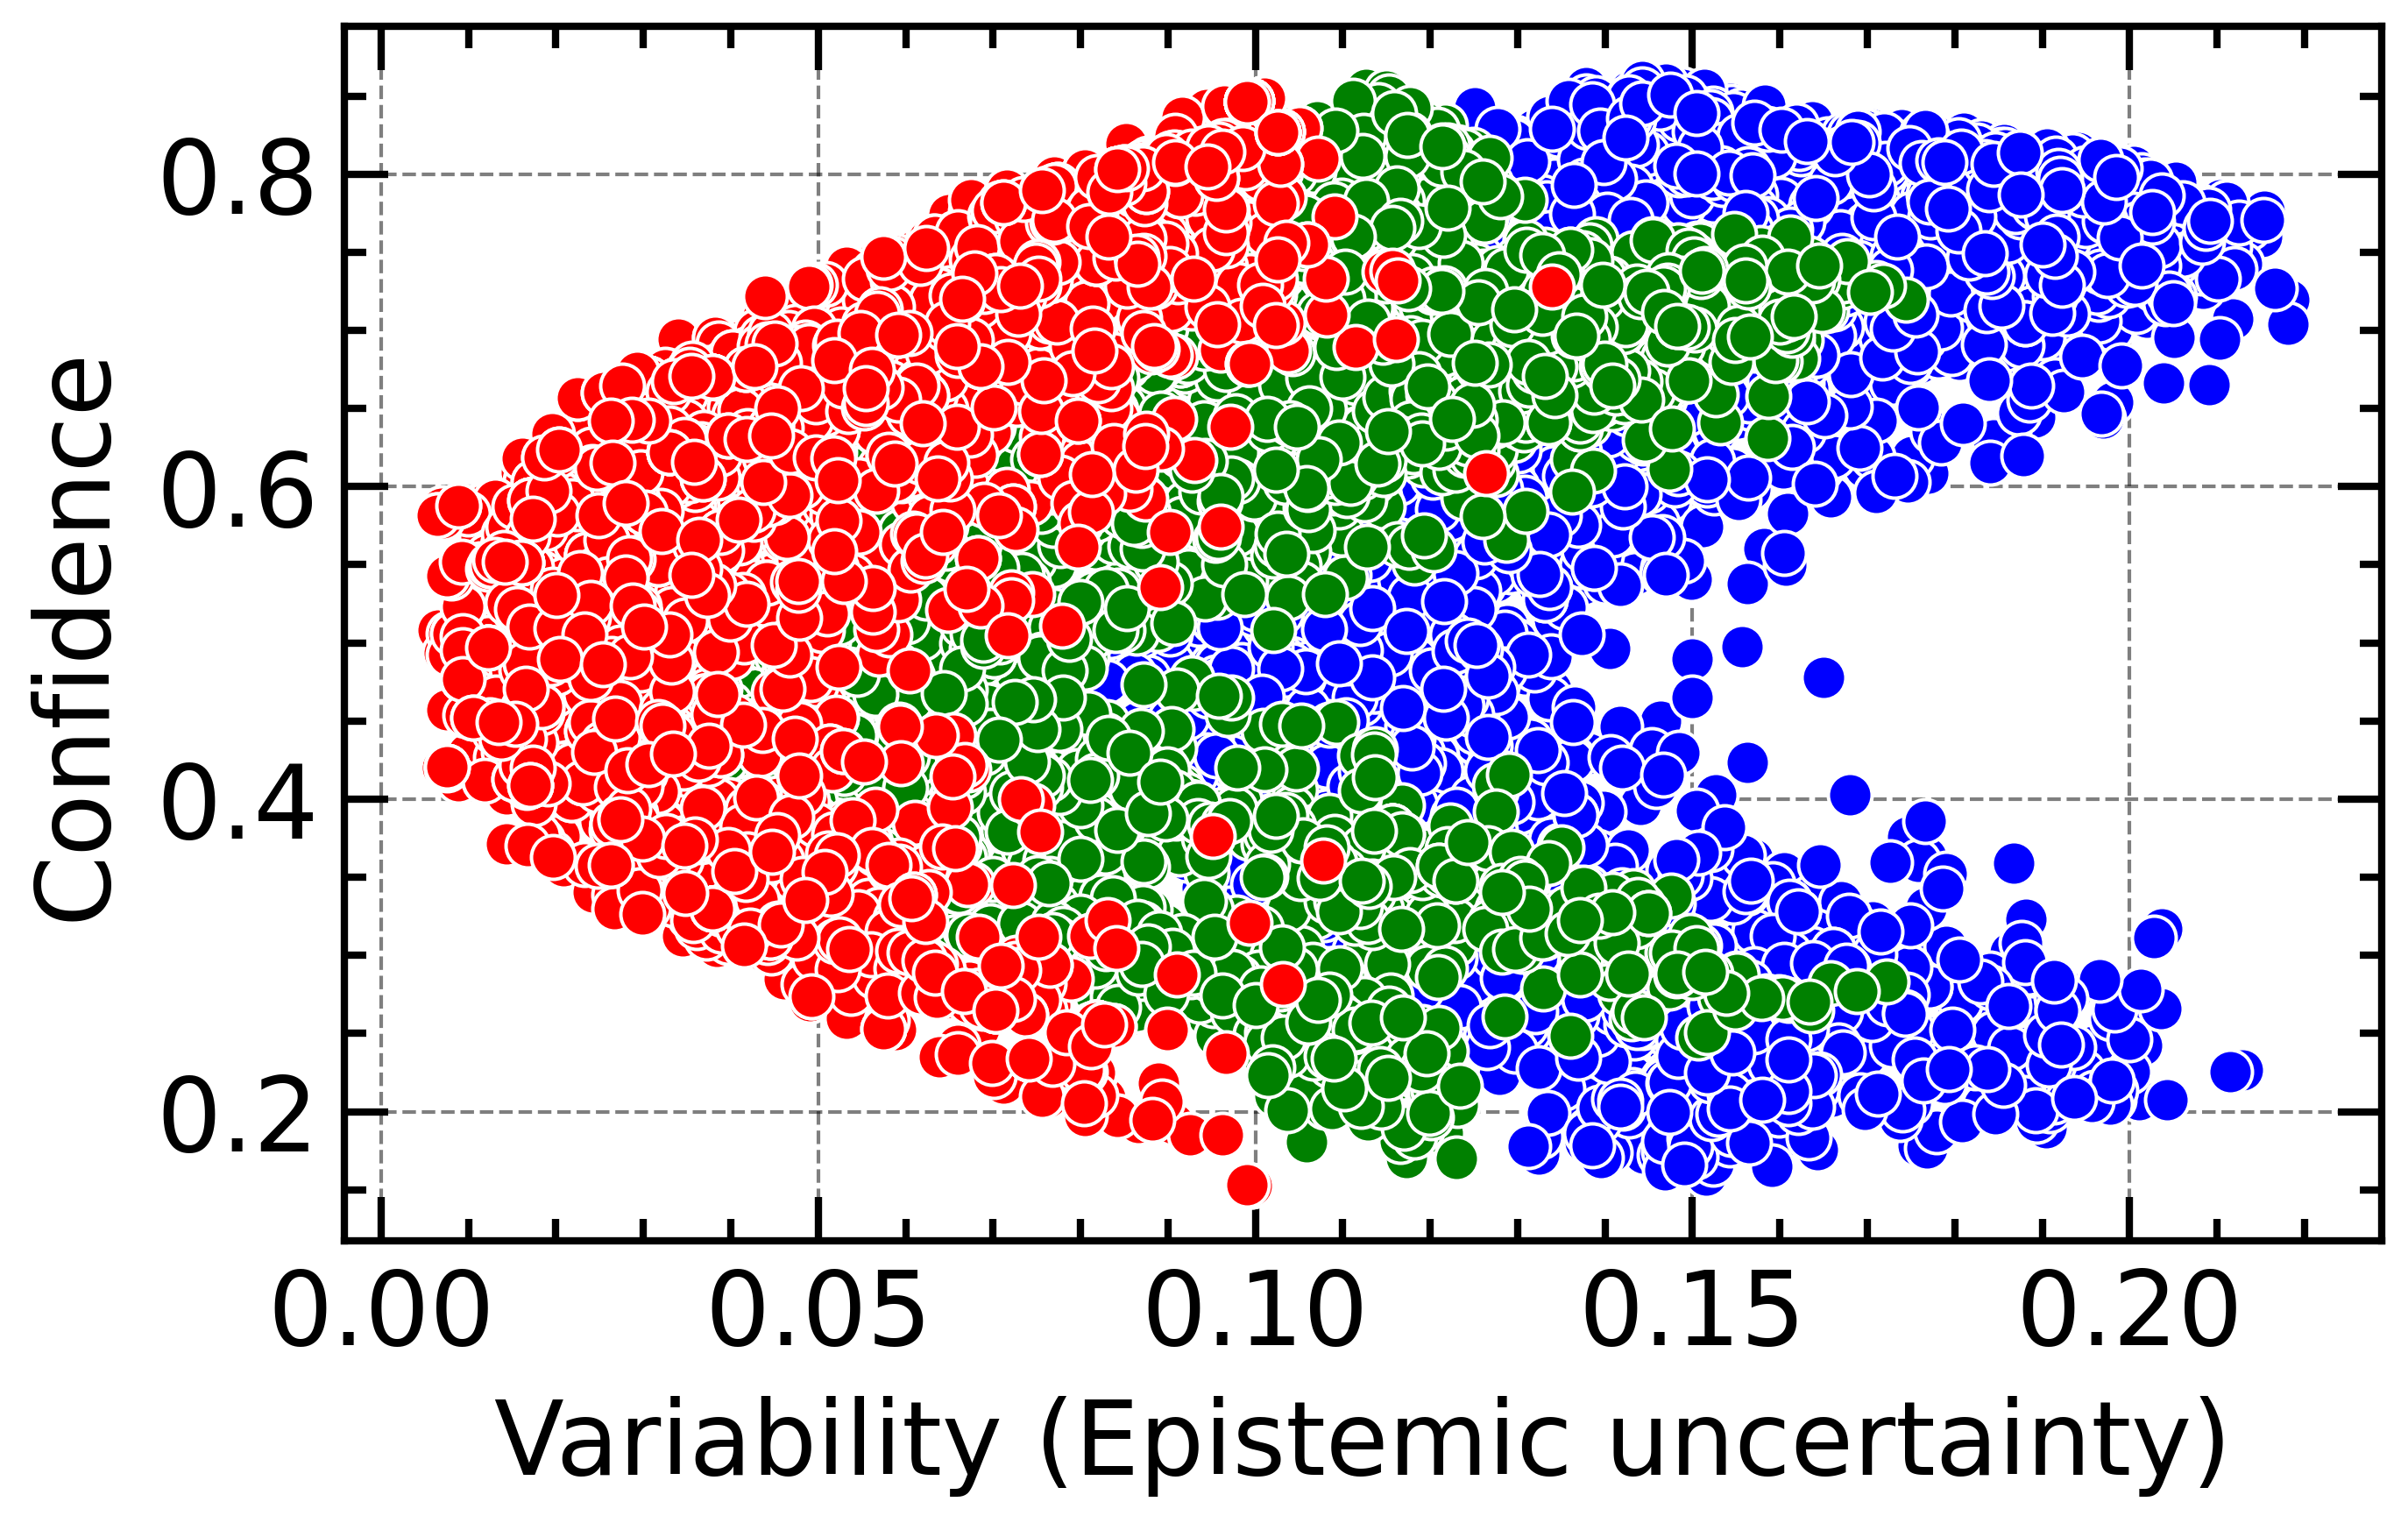

In [10]:
# DATAMAPS
plt.figure(figsize=(5, 3))

sns.scatterplot(x=dataiq_list[1].variability, y=dataiq_list[1].confidence, color="b")

sns.scatterplot(x=dataiq_list[2].variability, y=dataiq_list[2].confidence, color="g")

sns.scatterplot(x=dataiq_xgb.variability, y=dataiq_xgb.confidence, color="r")

plt.xlabel("Variability (Epistemic uncertainty)")
plt.ylabel("Confidence")
plt.show()
